<a href="https://colab.research.google.com/github/Bmiami988/Crop-Yield-Prediction/blob/main/Crop_Yield_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CROP YIELD PREDICTION**

-Predicts agricultural yields using weather, soil, and crop data with multiple ML models

## **LOAD DATA**

This cell loads the crop yield data and corresponding historical weather data from the two csv files. It displays the first 10 rows of each dataset which gives a quick overview of the structure and contents before any preprocessing or analysis begins.

In [28]:
import pandas as pd
import numpy as np

def load_data():
    """Load crop and weather data"""
    crop_df = pd.read_csv('/content/crop_yield_data.csv')
    weather_df = pd.read_csv('/content/weather_history.csv')


    return crop_df.head(10), weather_df.head(10)

if __name__ == "__main__":
    crop_df, weather_df = load_data()
    print("Crop Data:")
    print(crop_df.head())
    print(crop_df.shape)
    print("\nWeather Data:")
    print(weather_df.head())
    print(weather_df.shape)


Crop Data:
   farm_id  year location crop_type soil_type  farm_size_ha fertilizer_type  \
0        1  2020     Gulu     Beans  Volcanic           8.8         Organic   
1        2  2024   Soroti      Rice  Volcanic           1.0         Organic   
2        3  2022   Soroti     Beans  Volcanic           4.0         Organic   
3        4  2022     Arua     Beans     Sandy           1.7             NaN   
4        5  2021     Lira     Maize  Volcanic           4.9             NPK   

   yield_tons_ha  rainfall_mm  avg_temp_c  
0           1.06         13.6        25.2  
1           3.99         13.9        25.1  
2           1.12         13.9        25.1  
3           0.90         13.5        25.0  
4           2.05         13.7        25.1  
(10, 10)

Weather Data:
         date location  rainfall_mm  temperature_c  humidity_percent
0  2020-01-01     Gulu         14.4           27.6                80
1  2020-01-02     Gulu         23.3           24.8                47
2  2020-01-03     G

# **DATA PREPROCESING & FEATURE ENGINEERING**

This section prepares the crop and weather datasets by:

**Merging the data:**

The weather and crop datasets are joined based on location and year.

**Creating Lag Features:**

We add lagged rainfall and temperature values (1 to 3 years) to capture temporal dependencies.

**Aggregating Weather Data:**

We Compute mean annual weather statistics (including lagged features) by location and year.

**Feature Engineering:**

We create a custom feature (rainfall_soil_interaction) to reflect the combined influence of soil type and rainfall on yield.

**Preparing for Modeling:**

Our categorical variables (location, crop_type, etc.) are one-hot encoded.

The target variable (yield_tons_ha) is separated from features.

And this in turn returns feature matrix X, target y, and a preprocessing pipeline (preprocessor) for use in model training.

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

def add_lag_features(df, columns, lags):
    """Add lagged features for specified columns"""
    for col in columns:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df.groupby('location')[col].shift(lag)
    return df

def preprocess_data(weather_df, crop_df):
    """Preprocess and merge weather and crop data"""
    # Make copies to avoid modifying original DataFrames
    weather_df = weather_df.copy()
    crop_df = crop_df.copy()

    # Convert date to datetime and extract year
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    weather_df['year'] = weather_df['date'].dt.year

    # Add lag features to weather data
    weather_df = add_lag_features(weather_df, ['rainfall_mm', 'temperature_c'], [1, 2, 3])

    # Group weather data by location and year
    weather_agg = weather_df.groupby(['location', 'year']).agg({
        'rainfall_mm': 'mean',
        'temperature_c': 'mean',
        'humidity_percent': 'mean',
        'rainfall_mm_lag_1': 'mean',
        'rainfall_mm_lag_2': 'mean',
        'rainfall_mm_lag_3': 'mean',
        'temperature_c_lag_1': 'mean',
        'temperature_c_lag_2': 'mean',
        'temperature_c_lag_3': 'mean'
    }).reset_index()

    # Rename weather columns to distinguish from crop data
    weather_agg = weather_agg.rename(columns={
        'rainfall_mm': 'weather_rainfall',
        'temperature_c': 'weather_temp',
        'humidity_percent': 'weather_humidity'
    })

    # Merge with crop data
    merged_df = pd.merge(
        crop_df,
        weather_agg,
        on=['location', 'year'],
        how='left'
    )

    # Feature engineering
    soil_factors = {"Clay": 1.2, "Loam": 1.0, "Sandy": 0.8, "Volcanic": 1.3}
    merged_df['rainfall_soil_interaction'] = (
        merged_df['rainfall_mm'] *  # Using the crop dataframe's rainfall
        merged_df['soil_type'].map(soil_factors))

    return merged_df

def prepare_features_targets(df):
    """Prepare features (X) and target (y) for modeling"""
    # One-hot encoding setup
    categorical_cols = ['location', 'crop_type', 'soil_type', 'fertilizer_type']

    # Verify categorical columns exist
    for col in categorical_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Check if target column exists
    if 'yield_tons_ha' not in df.columns:
        raise ValueError("Target column 'yield_tons_ha' not found")

    X = df.drop(columns=['yield_tons_ha', 'farm_id'], errors='ignore')
    y = df['yield_tons_ha']

    return X, y, preprocessor

# Example usage
if __name__ == "__main__":
    # Load your data
    crop_df = pd.read_csv('/content/crop_yield_data.csv')
    weather_df = pd.read_csv('/content/weather_history.csv')

    # Process the data
    try:
        processed_df = preprocess_data(weather_df, crop_df)
        X, y, preprocessor = prepare_features_targets(processed_df)

        print("Processed DataFrame Columns:")
        print(processed_df.columns.tolist())

        print("\nProcessed DataFrame Sample:")
        print(processed_df.head())

        print("\nFeatures (X) Sample:")
        print(X.head())

    except Exception as e:
        print(f"Error processing data: {str(e)}")

Processed DataFrame Columns:
['farm_id', 'year', 'location', 'crop_type', 'soil_type', 'farm_size_ha', 'fertilizer_type', 'yield_tons_ha', 'rainfall_mm', 'avg_temp_c', 'weather_rainfall', 'weather_temp', 'weather_humidity', 'rainfall_mm_lag_1', 'rainfall_mm_lag_2', 'rainfall_mm_lag_3', 'temperature_c_lag_1', 'temperature_c_lag_2', 'temperature_c_lag_3', 'rainfall_soil_interaction']

Processed DataFrame Sample:
   farm_id  year location crop_type soil_type  farm_size_ha fertilizer_type  \
0        1  2020     Gulu     Beans  Volcanic           8.8         Organic   
1        2  2024   Soroti      Rice  Volcanic           1.0         Organic   
2        3  2022   Soroti     Beans  Volcanic           4.0         Organic   
3        4  2022     Arua     Beans     Sandy           1.7             NaN   
4        5  2021     Lira     Maize  Volcanic           4.9             NPK   

   yield_tons_ha  rainfall_mm  avg_temp_c  weather_rainfall  weather_temp  \
0           1.06         13.6     

# **MODEL TRAINING, EVALUATION & SAVING**

This section trains and compares multiple regression models to predict crop yield (yield_tons_ha) based on weather conditions, crop and soil types, and engineered features. Here's what's included:

**1.Feature Preprocessing:**

-Categorical features are one-hot encoded with missing value handling.

-Numerical features are imputed using the median strategy.

**2.Models Trained:**

-LinearRegression

-RandomForestRegressor

-XGBRegressor (XGBoost)

-HistGradientBoostingRegressor

**3.Evaluation Metrics:**

-MAE (Mean Absolute Error)

-RMSE (Root Mean Squared Error)

-R² Score (Explained Variance)

**4.Model Persistence:**

All trained models are saved as .pkl files for future use.

**5.Best Model Selection:**

The model with the lowest MAE is selected and reported as the best performer.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Identify categorical and numerical features
categorical_cols = ['location', 'crop_type', 'soil_type', 'fertilizer_type']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize models with preprocessing pipeline
models = {
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ]),
    "HistGradientBoosting": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ])
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        results[name] = {
            "MAE": mean_absolute_error(y_test, preds),
            "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
            "R2": model.score(X_test, y_test)
        }

        print(f"{name} Performance:")
        print(f"- MAE: {results[name]['MAE']:.2f}")
        print(f"- RMSE: {results[name]['RMSE']:.2f}")
        print(f"- R2: {results[name]['R2']:.2f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")


#save models
import pickle

# Save each model
for name, model in models.items():
    with open(f'/content/{name}.pkl', 'wb') as file:
        pickle.dump(model, file)
        print(f"Model {name} saved to {name}.pkl")


# Show best model
if results:
    best_model = min(results.items(), key=lambda x: x[1]['MAE'])
    print(f"\nBest model: {best_model[0]} (MAE: {best_model[1]['MAE']:.2f})")


Training Linear Regression...
Linear Regression Performance:
- MAE: 0.69
- RMSE: 0.99
- R2: 0.83

Training Random Forest...
Random Forest Performance:
- MAE: 0.75
- RMSE: 1.08
- R2: 0.80

Training XGBoost...
XGBoost Performance:
- MAE: 0.83
- RMSE: 1.20
- R2: 0.75

Training HistGradientBoosting...
HistGradientBoosting Performance:
- MAE: 0.67
- RMSE: 0.96
- R2: 0.84
Model Linear Regression saved to Linear Regression.pkl
Model Random Forest saved to Random Forest.pkl
Model XGBoost saved to XGBoost.pkl
Model HistGradientBoosting saved to HistGradientBoosting.pkl

Best model: HistGradientBoosting (MAE: 0.67)


# **MODEL EVALUATION AND FEATURE IMPORTANCE**

Here visualize the performance of each trained model and identify the most important features for crop yield prediction:

**Model Performance Bar Plot**

-Compares MAE and RMSE across all models using a grouped bar chart.

-Helps visually assess which models are more accurate and consistent.

**Feature Importance (Random Forest Only)**

-Extracts the top 10 most influential features contributing to yield predictions from the trained RandomForestRegressor.

-Combines one-hot encoded categorical feature names with numerical ones for better interpretability

<Figure size 1200x600 with 0 Axes>

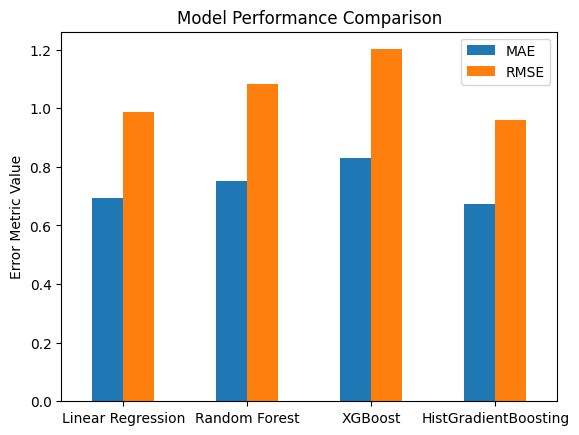

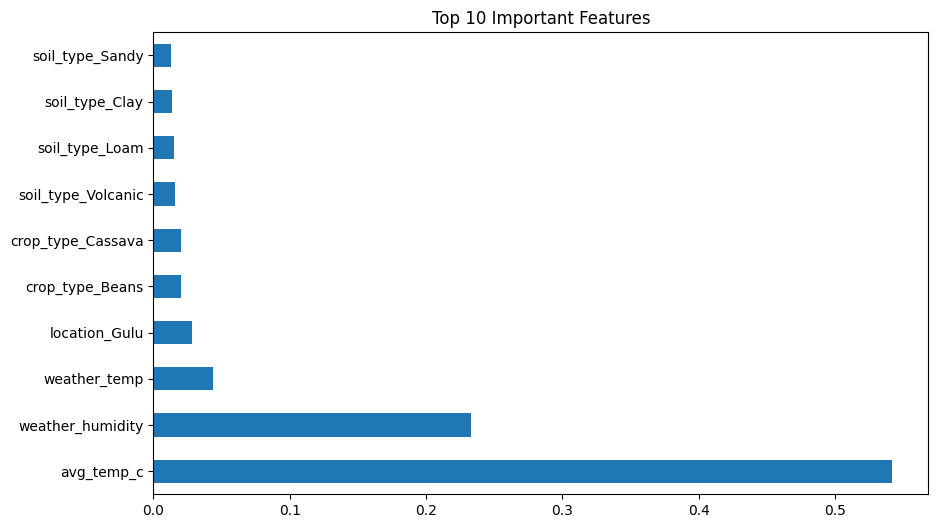

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model comparison
metrics_df = pd.DataFrame(results).T
plt.figure(figsize=(12, 6))
metrics_df[['MAE', 'RMSE']].plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Error Metric Value')
plt.show()

# Feature importance (for Random Forest)
plt.figure(figsize=(10, 6))

# Get the Random Forest model from the pipeline
rf_model = models["Random Forest"].named_steps['regressor']

# Get feature names after preprocessing
preprocessor = models["Random Forest"].named_steps['preprocessor']

# For one-hot encoded features, we need to get the feature names
try:
    # Get feature names from one-hot encoder
    ohe = preprocessor.named_transformers_['cat']
    categorical_features = ohe.get_feature_names_out(input_features=categorical_cols)

    # Combine with numerical features
    all_features = list(categorical_features) + numerical_cols

    # Create feature importance series
    feat_importances = pd.Series(rf_model.feature_importances_, index=all_features)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Important Features')
    plt.show()

except Exception as e:
    print(f"Could not plot feature importances: {str(e)}")

### **MAKE PREDICTIONS**

This function allows you to predict crop yield using the trained machine learning model for any new data point. It:

-Accepts key input parameters such as location, crop type, soil type, farm size, fertilizer used, and current weather conditions (rainfall & temperature).

-Constructs a DataFrame matching the training data schema, including:

Engineered features like rainfall-soil interaction.

Lag features to simulate temporal patterns in weather data.

-Uses the best-performing model like HistGradientBoosting to generate a yield prediction in tons per hectare.

In [41]:
import pandas as pd
from datetime import datetime

def predict_yield(model, location, crop, soil, farm_size, fertilizer, rainfall, temp):
    """Predict yield for new data with all required features"""
    # Create base input with provided features
    input_data = pd.DataFrame({
        'location': [location],
        'year': [datetime.now().year - 1],
        'crop_type': [crop],
        'soil_type': [soil],
        'farm_size_ha': [farm_size],
        'fertilizer_type': [fertilizer],
        'rainfall_mm': [rainfall],
        'avg_temp_c': [temp]
    })

    # Add engineered features
    soil_factors = {"Clay": 1.2, "Loam": 1.0, "Sandy": 0.8, "Volcanic": 1.3}
    input_data['rainfall_soil_interaction'] = input_data['rainfall_mm'] * input_data['soil_type'].map(soil_factors)

    # Add dummy weather lag features (set to current values if no history available)
    weather_lags = [
        'weather_rainfall', 'weather_temp', 'weather_humidity',
        'rainfall_mm_lag_1', 'rainfall_mm_lag_2', 'rainfall_mm_lag_3',
        'temperature_c_lag_1', 'temperature_c_lag_2', 'temperature_c_lag_3'
    ]

    for col in weather_lags:
        if 'rainfall' in col:
            input_data[col] = rainfall
        elif 'temp' in col:
            input_data[col] = temp
        else:
            input_data[col] = 60  # Default humidity value

    return model.predict(input_data)[0]

# Example usage
try:
    best_model = models["HistGradientBoosting"]
    prediction = predict_yield(
        model=best_model,
        location="Soroti",
        crop="Maize",
        soil="Loam",
        farm_size=7.0,
        fertilizer="NPK",
        rainfall=1200,
        temp=26
    )
    print(f"\nPredicted Yield: {prediction:.2f} tons/ha")
except Exception as e:
    print(f"Prediction failed: {str(e)}")


Predicted Yield: 2.34 tons/ha
